In [1]:
import os
import hist
import uproot
import statistics
import numpy as np
import pandas as pd
import awkward as ak
import mplhep as hep
from hist import Hist
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['grid.color'] = "#CCCCCC"
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['figure.edgecolor'] = 'none'

In [2]:
input_dir = "/Users/deep/Downloads/" # directory where file is located
file = uproot.open(f"{input_dir}/egps_upstreamtagger_8_1_gev.root") # open file
file.keys() # get keys

['LDMX_Events;4', 'LDMX_Events;3', 'LDMX_Run;1']

In [3]:
ldmx_events = file['LDMX_Events'] # Interested in LDMX_Events keys

In [4]:
# Build a dictionary to easily access keys
procName = "electron"
events = ak.zip({
        "TargetScoringPlaneHits":ak.zip({
            "id"         : ldmx_events[f"TargetScoringPlaneHits_{procName}.energy_"].array(library='ak'),
            "layerID"    : ldmx_events[f"TargetScoringPlaneHits_{procName}.layerID_"].array(library='ak'),
            "px"         : ldmx_events[f"TargetScoringPlaneHits_{procName}.px_"].array(library='ak'),
            "py"         : ldmx_events[f"TargetScoringPlaneHits_{procName}.py_"].array(library='ak'),
            "pz"         : ldmx_events[f"TargetScoringPlaneHits_{procName}.pz_"].array(library='ak'),
            "x"          : ldmx_events[f"TargetScoringPlaneHits_{procName}.x_"].array(library='ak'),
            "y"          : ldmx_events[f"TargetScoringPlaneHits_{procName}.y_"].array(library='ak'),
            "z"          : ldmx_events[f"TargetScoringPlaneHits_{procName}.z_"].array(library='ak'),
            "pdgID"      : ldmx_events[f"TargetScoringPlaneHits_{procName}.pdgID_"].array(library='ak'),
            "trackID"    : ldmx_events[f"TargetScoringPlaneHits_{procName}.trackID_"].array(library='ak'),
        }),
        "EcalScoringPlaneHits":ak.zip({
            "layerID"    : ldmx_events[f"EcalScoringPlaneHits_{procName}.layerID_"].array(library='ak'),
            "px"         : ldmx_events[f"EcalScoringPlaneHits_{procName}.px_"].array(library='ak'),
            "py"         : ldmx_events[f"EcalScoringPlaneHits_{procName}.py_"].array(library='ak'),
            "pz"         : ldmx_events[f"EcalScoringPlaneHits_{procName}.pz_"].array(library='ak'),
            "energy"     : ldmx_events[f"EcalScoringPlaneHits_{procName}.energy_"].array(library='ak'),
            "x"          : ldmx_events[f"EcalScoringPlaneHits_{procName}.x_"].array(library='ak'),
            "y"          : ldmx_events[f"EcalScoringPlaneHits_{procName}.y_"].array(library='ak'),
            "z"          : ldmx_events[f"EcalScoringPlaneHits_{procName}.z_"].array(library='ak'),
            "trackID"    : ldmx_events[f"EcalScoringPlaneHits_{procName}.trackID_"].array(library='ak'),
            "pdgID"      : ldmx_events[f"EcalScoringPlaneHits_{procName}.pdgID_"].array(library='ak'),
        }),
        "EcalClusters": ak.zip({
            "energy"     : ldmx_events[f"PFEcalClusters_{procName}.energy_"].array(library='ak'),
            "z"          : ldmx_events[f"PFEcalClusters_{procName}.centroidZ_"].array(library='ak'),
        })
    }, depth_limit=1)

In [5]:
events["TargetScoringPlaneHits"].id # Example to access a file with the dictionary

<Array [[5.08e+03, 5.52, ..., 0.376, 0.376], ...] type='10000 * var * float32'>

In [6]:
target_pt = np.hypot( # Get the hypotenuse of px and py
    events["TargetScoringPlaneHits"].px, 
    events["TargetScoringPlaneHits"].py
)
target_dR = np.hypot( # Get the hypotenuse of x and y
    events["TargetScoringPlaneHits"].x, 
    events["TargetScoringPlaneHits"].y
)

In [7]:
def extend_array(arr, new_attr, new_attr_name): # Add a new attribute to the array while retaining all existing attributes.
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

In [8]:
events["TargetScoringPlaneHits"] = extend_array(events["TargetScoringPlaneHits"], target_pt, "pt") # Add pt attribute for Target

In [9]:
events["TargetScoringPlaneHits"].pt # Get what pt is

<Array [[1.13e+03, 0.998, ..., 0.218, 0.218], ...] type='10000 * var * float32'>

In [10]:
events["TargetScoringPlaneHits"] = extend_array(events["TargetScoringPlaneHits"], target_dR, "dR") # Add dR attribute for target scoring

ecal_pt = np.hypot( # Hypoteneuse of px and py 
    events["EcalScoringPlaneHits"].px, 
    events["EcalScoringPlaneHits"].py
)
ecal_dR = np.hypot( # Hypoteneuse of x and y 
    events["EcalScoringPlaneHits"].x, 
    events["EcalScoringPlaneHits"].y
)

events["EcalScoringPlaneHits"] = extend_array(events["EcalScoringPlaneHits"], ecal_pt, "pt") # Add pt attribute for Ecal
events["EcalScoringPlaneHits"] = extend_array(events["EcalScoringPlaneHits"], ecal_dR, "dR") # Add dR attribute for Ecal

In [11]:
def electron_selection(arr): # Mask to pick out the relevant information to operate on the branch
    mask = (arr.pdgID == 11) # particle PdGID=11 corresponds to electron
    mask = mask & (arr.trackID==1) # first trackID
    mask = mask & (arr.z>0) # z position > 0
    mask = mask & (arr.pz>0)
    return mask

In [12]:
target_electron_selection = electron_selection(events["TargetScoringPlaneHits"]) # Perform the mask on Target scoring branch
target_electron_selection

<Array [[True, False, False, ..., False, False], ...] type='10000 * var * bool'>

In [13]:
target_electrons = events["TargetScoringPlaneHits"][target_electron_selection] # Select the value based on the mask 

In [14]:
target_electrons # Print selection with properties

<Array [[{id: 5.08e+03, ...}], ..., [{...}]] type='10000 * var * {id: float...'>

In [15]:
target_electrons.px # Print the x momentum property of the selected data in target scoring branch

<Array [[567], [-875], ..., [-1.94e+03]] type='10000 * var * float32'>

In [16]:
target_px = ak.firsts(target_electrons.px) # Take firsts or ravel to turn into 1D array
target_px

<Array [567, -875, -761, ..., -1.57e+03, -1.94e+03] type='10000 * ?float32'>

In [17]:
ak.fill_none(ak.pad_none(ak.firsts(target_electrons.px), 1, axis=0), value=-99999, axis=0) # Fill none value with 99999

<Array [567, -875, -761, ..., -1.57e+03, -1.94e+03] type='10000 * float64'>

In [18]:
def to_flat(arr): # Function to flatten the array and fill the empty values with -99999
    return ak.fill_none(ak.pad_none(ak.firsts(arr), 1, axis=0), value=-99999, axis=0).to_numpy()

In [19]:
target_px = to_flat(target_electrons.px) # Get the target px byt flattening the px value
target_px

array([  566.87841797,  -875.09820557,  -760.59796143, ...,
        -225.71166992, -1565.70837402, -1936.53869629])

In [20]:
ecal_truth_electron_selection = electron_selection(events["EcalScoringPlaneHits"]) # Run the mask on Ecal scoring 
ecal_truth_electrons = events["EcalScoringPlaneHits"][ecal_truth_electron_selection] # Select the needed values
ecal_truth_electrons.px # Print the x momentum

<Array [[319], [-937], ..., [-1.63e+03], [-2e+03]] type='10000 * var * float32'>

In [21]:
ecal_truth_px = to_flat(ecal_truth_electrons.px) # flatten the x momentum
ecal_truth_px

array([  318.93411255,  -936.91424561,  -815.59417725, ...,
        -283.17382812, -1626.1328125 , -1998.18066406])

In [22]:
ecal_truth_x = to_flat(ecal_truth_electrons.x) # Flatten the x position of ecal scoring
target_truth_x = to_flat(target_electrons.x) # Flatten the x position of the target scoring
ecal_truth_x - target_truth_x

array([ 25.14263439, -76.95968246, -39.63527185, ..., -51.62272024,
       -60.59861755, -73.10333157])

In [23]:
h_target = hist.Hist( # Create a 2D hist with x vs y momentum for target scoring
    hist.axis.Regular(20, -1000, 1000, name="target_px", label="target_px [MeV]"),
    hist.axis.Regular(20, -1000, 1000, name="target_py", label="target_py [MeV]"),
)

In [24]:
to_flat(target_electrons.px)

array([  566.87841797,  -875.09820557,  -760.59796143, ...,
        -225.71166992, -1565.70837402, -1936.53869629])

In [25]:
h_target.fill( # Fill with value
    target_px = to_flat(target_electrons.px),
    target_py = to_flat(target_electrons.py),
)

Hist(
  Regular(20, -1000, 1000, name='target_px', label='target_px [MeV]'),
  Regular(20, -1000, 1000, name='target_py', label='target_py [MeV]'),
  storage=Double()) # Sum: 6106.0 (10000.0 with flow)

In [26]:
h_ecal = hist.Hist( # Create a 2D histogram of x vs y momentum for the ecal
    hist.axis.Regular(20, -1000, 1000, name="ecal_truth_px"),
    hist.axis.Regular(20, -1000, 1000, name="ecal_truth_py"),
)

In [27]:
h_ecal.fill( # Fill the histogram
    ecal_truth_px = to_flat(ecal_truth_electrons.px),
    ecal_truth_py = to_flat(ecal_truth_electrons.py),
) 

Hist(
  Regular(20, -1000, 1000, name='ecal_truth_px'),
  Regular(20, -1000, 1000, name='ecal_truth_py'),
  storage=Double()) # Sum: 6288.0 (10000.0 with flow)

In [28]:
to_flat(ecal_truth_electrons.x)

array([ 34.11579514, -84.50583649, -40.3638649 , ..., -45.32003403,
       -69.44358826, -82.33317566])

In [29]:
truth_dx = to_flat(ecal_truth_electrons.x) - to_flat(target_electrons.x)
truth_dy = to_flat(ecal_truth_electrons.y) - to_flat(target_electrons.y)

In [30]:
hdx = hist.Hist( # Create a 1D histogram for dx
    hist.axis.Regular(20, -100, 100, name="dx"),
)
hdx.fill( # fill with the histogram
    dx = truth_dx,
)

Hist(Regular(20, -100, 100, name='dx'), storage=Double()) # Sum: 9968.0 (10000.0 with flow)

In [31]:
hdy = hist.Hist( # create a 1D histogram of dy
    hist.axis.Regular(20, -100, 100, name="dy"),
)
hdy.fill(
    dy = truth_dy,
)

Hist(Regular(20, -100, 100, name='dy'), storage=Double()) # Sum: 9984.0 (10000.0 with flow)

In [32]:
h3 = hist.Hist( # Create a 3D hist with values of dx, px of ecal and Ecal energy
    hist.axis.Regular(20, -100, 100, name="truth_dx"),
    hist.axis.Regular(20, -1000, 1000, name="truth_ecal_px"),
    hist.axis.Regular(10, 0, 8000, name="truth_ecal_E"),
)
h3.fill(
    truth_dx = to_flat(ecal_truth_electrons.x) - to_flat(target_electrons.x),
    truth_ecal_px = to_flat(ecal_truth_electrons.px),
    truth_ecal_E = to_flat(ecal_truth_electrons.energy)
)

Hist(
  Regular(20, -100, 100, name='truth_dx'),
  Regular(20, -1000, 1000, name='truth_ecal_px'),
  Regular(10, 0, 8000, name='truth_ecal_E'),
  storage=Double()) # Sum: 7854.0 (10000.0 with flow)

In [33]:
h3.project("truth_ecal_px","truth_dx") # projection of dx as a function of px

Hist(
  Regular(20, -1000, 1000, name='truth_ecal_px'),
  Regular(20, -100, 100, name='truth_dx'),
  storage=Double()) # Sum: 7854.0 (10000.0 with flow)

In [34]:
h3.project("truth_ecal_px","truth_ecal_E")  # projection of Ecal energy as a function of px

Hist(
  Regular(20, -1000, 1000, name='truth_ecal_px'),
  Regular(10, 0, 8000, name='truth_ecal_E'),
  storage=Double()) # Sum: 7873.0 (10000.0 with flow)

In [35]:
def get_mean(h): # h is a hist
    n, bins = h.to_numpy()
    # https://stackoverflow.com/questions/50786699/how-to-calculate-the-standard-deviation-from-a-histogram-python-matplotlib
    try:
        mids = 0.5*(bins[1:] + bins[:-1])
        mean = np.average(mids, weights=n)
    except:
        mean = 0
    return mean

In [36]:
get_mean(h3[0,:,5]) # for each bin get the most probable value of px

0

In [37]:
get_mean(h3[0,:,0])

-210.0

In [38]:
h3[5,:,5].to_numpy()

(array([14., 45., 23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000.,  -900.,  -800.,  -700.,  -600.,  -500.,  -400.,  -300.,
         -200.,  -100.,     0.,   100.,   200.,   300.,   400.,   500.,
          600.,   700.,   800.,   900.,  1000.]))

In [39]:
h3[5,:,5].to_numpy()[0] # First element is the counts

array([14., 45., 23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [40]:
h3[5,:,5].to_numpy()[1] # second is the bin ranges

array([-1000.,  -900.,  -800.,  -700.,  -600.,  -500.,  -400.,  -300.,
        -200.,  -100.,     0.,   100.,   200.,   300.,   400.,   500.,
         600.,   700.,   800.,   900.,  1000.])

In [41]:
# STEP 1: get these 2d array weights
weights = []
# weight -> mean in each (bin in E, bin in dx(dy))
# weight[0,0] ~ -210
# weight[0,5] ~ 0

In [42]:
weights = np.zeros((20, 10)) # Weight for ecal_px of eeach bin in  dx and "truth_ecal_E"
weight = get_mean(h3[0, :, 0])
weights[0, 0] = weight # Append the weight to the list
print (weights)

[[-210.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.

In [43]:
weights = np.zeros((20, 10))
for dx_bin in range(20):
    for E_bin in range(10):
        # Calculate the weight for this bin using the get_mean function
        weight = get_mean(h3[dx_bin, :, E_bin])
        weights[dx_bin, E_bin] = weight

In [44]:
print (weights)

[[-210.         -416.66666667 -650.            0.            0.
     0.            0.            0.            0.            0.        ]
 [-137.5        -452.7027027  -686.11111111 -897.36842105    0.
     0.            0.            0.            0.            0.        ]
 [-141.66666667 -378.84615385 -610.         -856.25       -950.
     0.            0.            0.            0.            0.        ]
 [-150.         -351.81818182 -544.82758621 -758.33333333 -916.66666667
  -950.            0.            0.            0.            0.        ]
 [-143.33333333 -304.05405405 -460.38961039 -644.18604651 -811.40350877
  -932.35294118    0.            0.            0.            0.        ]
 [-125.         -256.41025641 -380.85106383 -526.31578947 -673.68421053
  -839.02439024 -930.95238095 -950.            0.            0.        ]
 [ -83.33333333 -200.         -307.33333333 -432.22222222 -531.6091954
  -642.92929293 -759.72222222 -863.58024691 -925.6097561  -942.85714286]
 [ -59.523

In [45]:
dy_h3 = hist.Hist( # For plotting dy 3D histogram
    hist.axis.Regular(20, -100, 100, name="truth_dy"),
    hist.axis.Regular(20, -1000, 1000, name="truth_ecal_py"),
    hist.axis.Regular(10, 0, 8000, name="truth_ecal_E"),
)
dy_h3.fill(
    truth_dy = to_flat(ecal_truth_electrons.y) - to_flat(target_electrons.y),
    truth_ecal_py = to_flat(ecal_truth_electrons.py),
    truth_ecal_E = to_flat(ecal_truth_electrons.energy)
)

Hist(
  Regular(20, -100, 100, name='truth_dy'),
  Regular(20, -1000, 1000, name='truth_ecal_py'),
  Regular(10, 0, 8000, name='truth_ecal_E'),
  storage=Double()) # Sum: 7876.0 (10000.0 with flow)

In [46]:
dy_weights =  np.zeros((20, 10))
for dy_bin in range(20):
    for E_bin in range(10):
        # Calculate the weight for this bin using the get_mean function
        dy_weight = get_mean(dy_h3[dy_bin, :, E_bin])
        dy_weights[dy_bin, E_bin] = dy_weight

In [47]:
truth_dx = to_flat(ecal_truth_electrons.x) - to_flat(target_electrons.x)
truth_ecal_E = to_flat(ecal_truth_electrons.energy)
print (f"the the length of dx is: {len (truth_dx)} the length of ecal E is : {len(truth_ecal_E)} the size of weight is : {len(weights)}")
print (f"the the shape of dx is: {truth_dx.shape} the shape of ecal E is : {truth_ecal_E.shape} the shape of weight is : {weights.shape}")

the the length of dx is: 10000 the length of ecal E is : 10000 the size of weight is : 20
the the shape of dx is: (10000,) the shape of ecal E is : (10000,) the shape of weight is : (20, 10)


In [48]:
dx_bins = h3.project("truth_dx").to_numpy()[1] # Index 1 corresponds to bin ranges
ex_bins = h3.project("truth_ecal_E").to_numpy()[1] # Index 1 corresponds to bin ranges
print (f"{dx_bins}, \n {ex_bins}")

[-100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.   10.
   20.   30.   40.   50.   60.   70.   80.   90.  100.], 
 [   0.  800. 1600. 2400. 3200. 4000. 4800. 5600. 6400. 7200. 8000.]


In [49]:
def get_weight(value, e_value):
    tmp = 0 # indexes to return
    tmp2 = 0
    condition = (value < -100) | (value > 100) | (e_value < 0) | (e_value > 8000) # Out of bound index
    
    if np.any(condition):
        return -99999 # Default value for out of bound
    for i in range(len(dx_bins)): # Loop through dx bins and compare each index to the value passed
        if value > dx_bins[i]:
            tmp = i
        else:
            break
    for j in range(len(ex_bins)): # Loop through energy bins and compare each index to the value passed
        if e_value > ex_bins[j]:
            tmp2 = j
        else:
            break
    tmp = min(tmp, len(weights) - 1) # Keep tmp and tmp2 within the index of weights array
    tmp2 = min(tmp2, len(weights[0]) - 1)

    return weights[tmp][tmp2] # Return the value based on the value of temp(s)

In [50]:
# STEP 3: 
    # get px using reference histogram
    # compare that to the truth px
    # px_reference - truth_px ~ 0

In [51]:
recon_px= []
for i in range (10000):
    tmp = get_weight(truth_dx[i], truth_ecal_E[i])
    recon_px.append(tmp)
recon_px

[346.59090909090907,
 -856.25,
 -759.7222222222222,
 -389.3258426966292,
 -950.0,
 -390.6779661016949,
 -432.22222222222223,
 607.1428571428571,
 0.0,
 -759.7222222222222,
 -477.4725274725275,
 570.8333333333334,
 -91.07142857142857,
 0.0,
 0.0,
 -91.07142857142857,
 -811.4035087719299,
 -916.6666666666666,
 -897.3684210526316,
 607.1428571428571,
 -644.1860465116279,
 656.8493150684932,
 -642.929292929293,
 0.0,
 417.81609195402297,
 950.0,
 -180.18867924528303,
 262.962962962963,
 818.5714285714286,
 627.6470588235294,
 575.3012048192771,
 -803.125,
 -380.8510638297872,
 -380.8510638297872,
 908.1395348837209,
 886.5384615384615,
 703.8461538461538,
 607.1428571428571,
 688.5964912280701,
 601.3888888888889,
 477.77777777777777,
 260.8433734939759,
 -759.7222222222222,
 55.714285714285744,
 627.6470588235294,
 -256.4102564102564,
 950.0,
 -305.17241379310343,
 -803.125,
 -180.18867924528303,
 -59.523809523809526,
 -237.2093023255814,
 -50.0,
 -531.6091954022988,
 0.0,
 0.0,
 50.00000

In [52]:
filtered_recon_px = [value for value in recon_px if value != -99999] # Filter out -99999 from recon_px
min_value = min(filtered_recon_px) # Calculate the minimum and maximum values
max_value = max(filtered_recon_px)
print(f"The min: {min_value} The max: {max_value}")

The min: -950.0 The max: 950.0


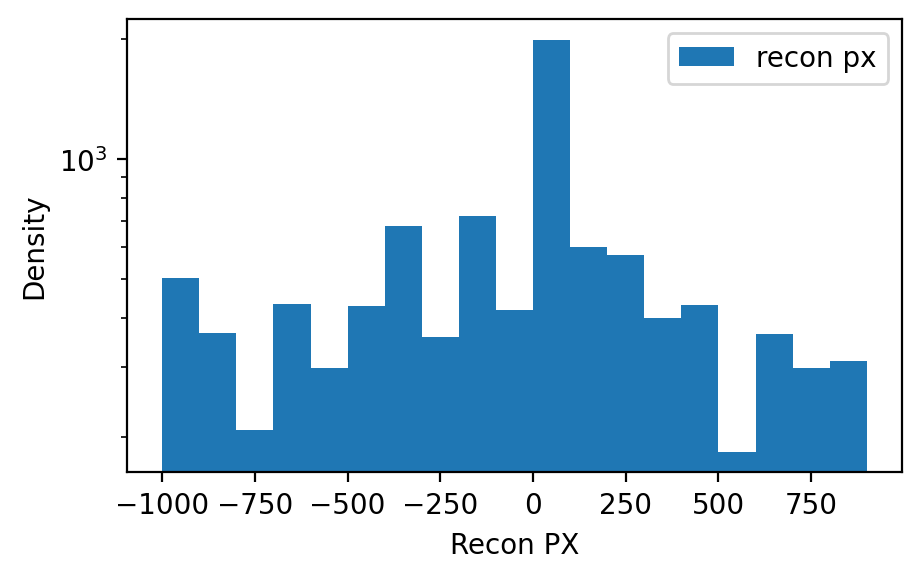

In [53]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the x_momentum
ax.hist(recon_px, label='recon px',bins = np.arange(-1000, 1000, 100))
ax.set_xlabel('Recon PX')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [54]:
truth_ecal_px = to_flat(ecal_truth_electrons.px)
print(f"The min: {min(truth_ecal_px)} The max: {max(truth_ecal_px)}")
filtered_truth_px = [value for value in truth_ecal_px if value != -99999] # Filter out -99999 from ecal_px
min_value = min(filtered_truth_px) # Calculate the minimum and maximum values
max_value = max(filtered_truth_px)
print(f"The min: {min_value} The max: {max_value}")

The min: -99999.0 The max: 2542.226806640625
The min: -2637.076904296875 The max: 2542.226806640625


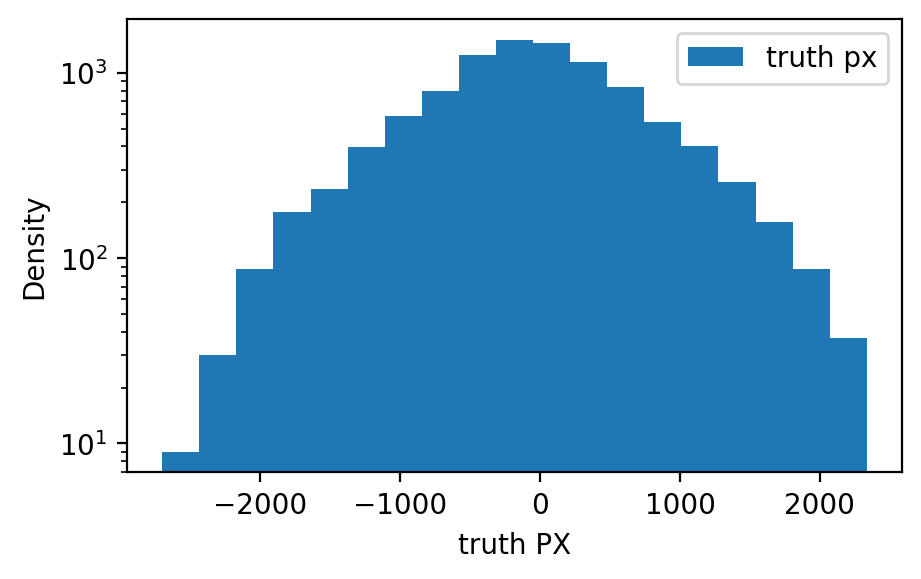

In [55]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the x_momentum
ax.hist(truth_ecal_px, label='truth px',bins = np.arange(-2700, 2600, 265))
ax.set_xlabel('truth PX')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [56]:
residual_px = recon_px - truth_ecal_px
residual_px = [value for value in residual_px if value > -90000] # Filter out -99999 from residual_px
min_value = min(residual_px) # Calculate the minimum and maximum values
max_value = max(residual_px)
print(f"The min: {min_value} The max: {max_value}")

The min: -2542.226806640625 The max: 2637.076904296875


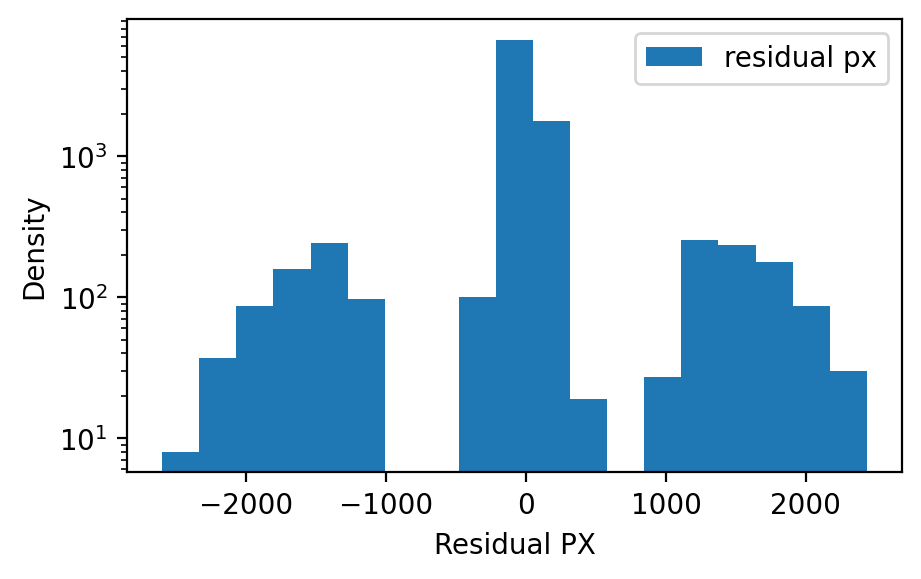

In [57]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the x_momentum
ax.hist(residual_px, label='residual px',bins = np.arange(-2600, 2700, 265))
ax.set_xlabel('Residual PX')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [58]:
# STEP 4: redo this for dy

In [66]:
truth_dy = to_flat(ecal_truth_electrons.y) - to_flat(target_electrons.y)

In [65]:
dy_bins = dy_h3.project("truth_dy").to_numpy()[1] # Index 1 corresponds to bin ranges
ey_bins = dy_h3.project("truth_ecal_E").to_numpy()[1] # Index 1 corresponds to bin ranges
print (f"{dy_bins}, \n {ey_bins}")

[-100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.   10.
   20.   30.   40.   50.   60.   70.   80.   90.  100.], 
 [   0.  800. 1600. 2400. 3200. 4000. 4800. 5600. 6400. 7200. 8000.]


In [67]:
recon_py= []
for i in range (10000):
    tmp = get_weight(truth_dy[i], truth_ecal_E[i])
    recon_py.append(tmp)
recon_py

[-673.6842105263158,
 146.00000000000003,
 517.5324675324675,
 886.5384615384615,
 607.1428571428571,
 0.0,
 258.7912087912088,
 -839.0243902439024,
 -930.952380952381,
 703.8461538461538,
 -299.4117647058824,
 22.46376811594205,
 -256.4102564102564,
 -950.0,
 -347.0149253731343,
 -200.0,
 45.45454545454548,
 -916.6666666666666,
 -79.26829268292683,
 607.1428571428571,
 360.958904109589,
 0.0,
 260.8433734939759,
 459.8360655737705,
 0.0,
 0.0,
 0.0,
 201.72413793103448,
 146.00000000000003,
 477.77777777777777,
 101.72413793103452,
 0.0,
 -307.3333333333333,
 266.1290322580645,
 -950.0,
 -237.2093023255814,
 -120.96774193548387,
 -477.4725274725275,
 -526.3157894736842,
 -526.3157894736842,
 -94.5945945945946,
 766.4383561643835,
 892.1052631578947,
 0.0,
 -531.6091954022988,
 13.793103448275883,
 299.2957746478873,
 688.5964912280701,
 745.4545454545455,
 0.0,
 44.73684210526318,
 -916.6666666666666,
 29.16666666666669,
 -950.0,
 0.0,
 945.0,
 -143.33333333333334,
 201.72413793103448

In [68]:
filtered_recon_py = [value for value in recon_py if value != -99999] # Filter out -99999 from recon_py
min_value = min(filtered_recon_py) # Calculate the minimum and maximum values
max_value = max(filtered_recon_py)
print(f"The min: {min_value} The max: {max_value}")

The min: -950.0 The max: 950.0


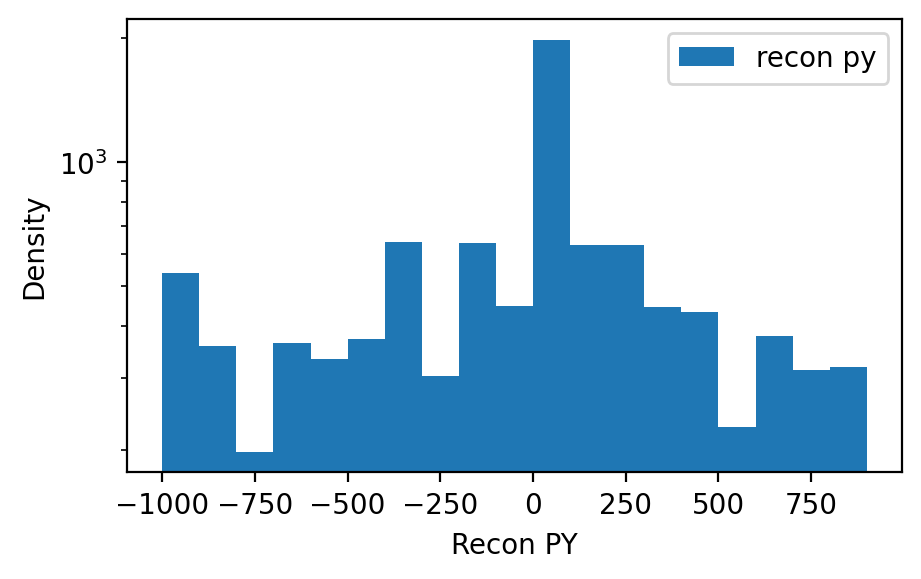

In [69]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the x_momentum
ax.hist(recon_py, label='recon py',bins = np.arange(-1000, 1000, 100))
ax.set_xlabel('Recon PY')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [71]:
truth_ecal_py = to_flat(ecal_truth_electrons.py)
filtered_truth_py = [value for value in truth_ecal_py if value != -99999] # Filter out -99999 from ecal_py
min_value = min(filtered_truth_py) # Calculate the minimum and maximum values
max_value = max(filtered_truth_py)
print(f"The min: {min_value} The max: {max_value}")

The min: -2580.824951171875 The max: 2655.503662109375


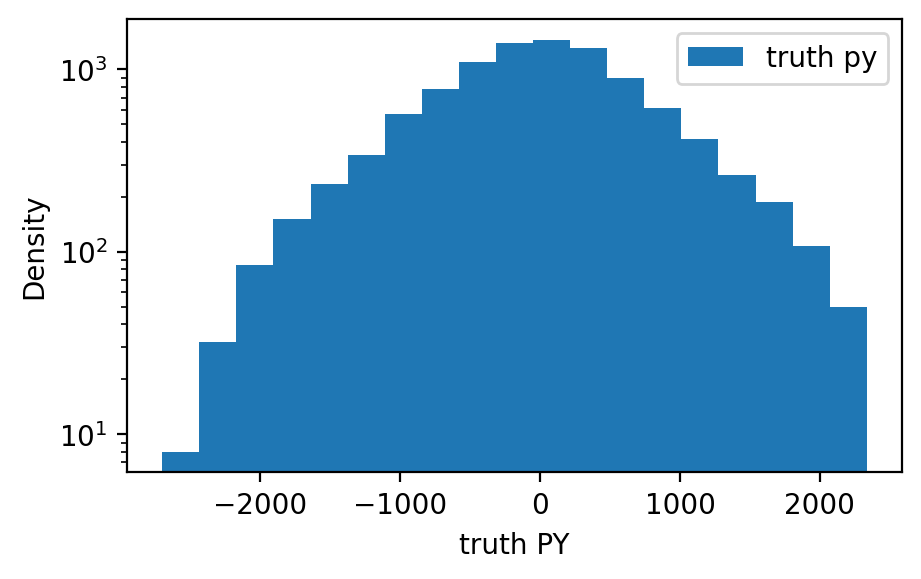

In [72]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the y_momentum
ax.hist(truth_ecal_py, label='truth py',bins = np.arange(-2700, 2600, 265))
ax.set_xlabel('truth PY')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [73]:
residual_py = recon_py - truth_ecal_py
residual_py = [value for value in residual_py if value > -90000] # Filter out -99999 from residual_py
min_value = min(residual_py) # Calculate the minimum and maximum values
max_value = max(residual_py)
print(f"The min: {min_value} The max: {max_value}")

The min: -2655.503662109375 The max: 2580.824951171875


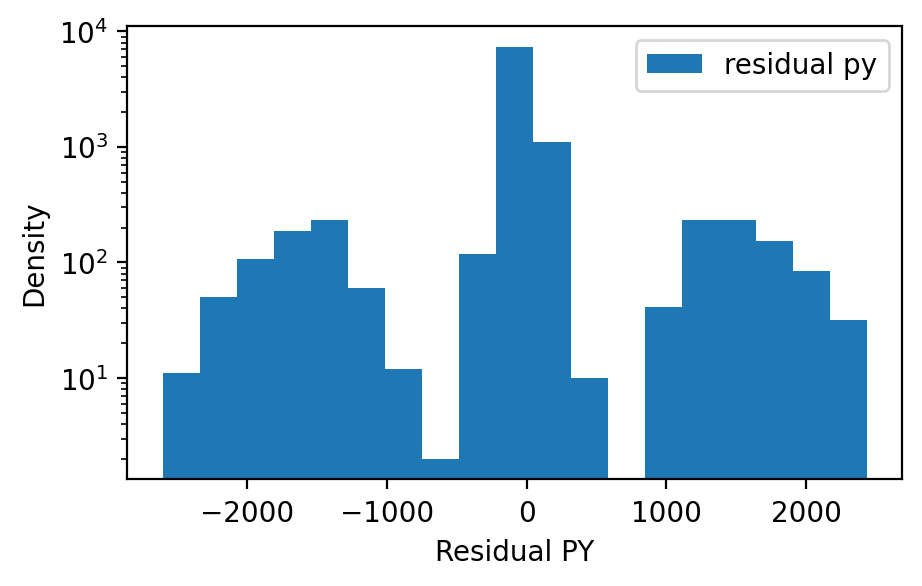

In [74]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the y_momentum
ax.hist(residual_py, label='residual py',bins = np.arange(-2600, 2700, 265))
ax.set_xlabel('Residual PY')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()